# Análise de Cesta 

### 🎲 Utilizando o algoritmo "A Priori" de mineração de dados

### 🔣 Dicionário de Dados

**Legenda das Colunas da Tabela de Regras de Associação**

* **`antecedents`**:
    * O(s) código(s) do(s) produto(s) no lado esquerdo da regra (item X em "SE compra X...").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`consequents`**:
    * O(s) código(s) do(s) produto(s) no lado direito da regra (item Y em "...ENTÃO compra Y").
    * Tipo: Texto (object) ou Número (int64), idealmente tratado como Texto.

* **`antecedent support`**:
    * Frequência/proporção de transações que contêm o antecedente (X). `P(X)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`consequent support`**:
    * Frequência/proporção de transações que contêm o consequente (Y). `P(Y)`.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`support`**:
    * Frequência/proporção de transações que contêm *tanto* o antecedente (X) *quanto* o consequente (Y). `P(X e Y)`.
    * Indica a popularidade geral da *combinação* X e Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`confidence`**:
    * Probabilidade de encontrar o consequente (Y) em uma transação, *dado que* ela já contém o antecedente (X). `P(Y | X)`.
    * Mede a *confiabilidade* ou força preditiva da regra na direção X -> Y.
    * Tipo: Número Decimal (float64). *Formatar como Percentual (%) para visualização.*

* **`lift`**:
    * Mede quantas vezes a presença de X *aumenta* a probabilidade de comprar Y, comparado à probabilidade normal de comprar Y. `Conf(X->Y) / Sup(Y)`.
    * Lift > 1 indica associação positiva (interessante); Lift = 1 indica independência; Lift < 1 indica associação negativa.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal (ex: 2 casas).*

* **`representativity`**: (Atenção: Métrica menos padronizada, pode ter definições variadas)
    * Tenta medir quão "representativa" é a regra ou a dependência encontrada, possivelmente comparando métricas observadas com esperadas.
    * *Verificar a documentação da biblioteca usada ou a fórmula específica para interpretação precisa.*
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`leverage`**:
    * Mede a diferença entre a frequência observada de X e Y juntos e a frequência esperada se fossem independentes. `Sup(X,Y) - Sup(X)*Sup(Y)`.
    * Valores > 0 indicam que aparecem juntos mais que o esperado.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`conviction`**:
    * Mede o grau de "implicação" da regra. Alto valor sugere que o consequente depende fortemente do antecedente. `(1-Sup(Y))/(1-Conf(X->Y))`.
    * Pode ser muito alto ou infinito.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`zhangs_metric`**:
    * Métrica robusta (varia de -1 a +1) que mede a associação levando em conta suporte e confiança, sem ser afetada pela popularidade isolada.
    * Valores próximos de +1 indicam forte associação positiva.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`jaccard`**:
    * Coeficiente de Jaccard: similaridade entre os conjuntos de transações contendo X e Y. `Sup(X,Y) / (Sup(X)+Sup(Y)-Sup(X,Y))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`certainty`**:
    * Mede o ganho de "certeza" proporcionado pela regra. `(Conf(X->Y) - Sup(Y)) / (1 - Sup(Y))`.
    * Varia de -1 a 1.
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal.*

* **`kulczynski`**:
    * Média das confianças nas duas direções: `0.5 * (Conf(X->Y) + Conf(Y->X))`.
    * Valor entre 0 e 1 (pode ser visto como %).
    * Tipo: Número Decimal (float64). *Formatar como Número Decimal ou Percentual (%).*

* **`Nomes_Antecedents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) antecedente(s).
    * Tipo: Texto (object).

* **`Nomes_Consequents`**:
    * O(s) nome(s) legível(is) do(s) produto(s) consequente(s).
    * Tipo: Texto (object).


### 📚 Packages

In [1]:
import polars as pl
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


### 🧩 E.D.A
- Dados extraídos do Kaggle - [Brazilian E-Commerce Public Dataset by Olist](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)

In [2]:
orders = pl.read_csv("../data/olist_orders_dataset.csv")
order_items = pl.read_csv("../data/olist_order_items_dataset.csv")
products = pl.read_csv("../data/olist_products_dataset.csv")

In [7]:
orders.head()

order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
str,str,str,str,str,str,str,str
"""e481f51cbdc54678b7cc49136f2d6a…","""9ef432eb6251297304e76186b10a92…","""delivered""","""2017-10-02 10:56:33""","""2017-10-02 11:07:15""","""2017-10-04 19:55:00""","""2017-10-10 21:25:13""","""2017-10-18 00:00:00"""
"""53cdb2fc8bc7dce0b6741e21502734…","""b0830fb4747a6c6d20dea0b8c802d7…","""delivered""","""2018-07-24 20:41:37""","""2018-07-26 03:24:27""","""2018-07-26 14:31:00""","""2018-08-07 15:27:45""","""2018-08-13 00:00:00"""
"""47770eb9100c2d0c44946d9cf07ec6…","""41ce2a54c0b03bf3443c3d931a3670…","""delivered""","""2018-08-08 08:38:49""","""2018-08-08 08:55:23""","""2018-08-08 13:50:00""","""2018-08-17 18:06:29""","""2018-09-04 00:00:00"""
"""949d5b44dbf5de918fe9c16f97b45f…","""f88197465ea7920adcdbec7375364d…","""delivered""","""2017-11-18 19:28:06""","""2017-11-18 19:45:59""","""2017-11-22 13:39:59""","""2017-12-02 00:28:42""","""2017-12-15 00:00:00"""
"""ad21c59c0840e6cb83a9ceb5573f81…","""8ab97904e6daea8866dbdbc4fb7aad…","""delivered""","""2018-02-13 21:18:39""","""2018-02-13 22:20:29""","""2018-02-14 19:46:34""","""2018-02-16 18:17:02""","""2018-02-26 00:00:00"""


In [8]:
order_items.head()

order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
str,i64,str,str,str,f64,f64
"""00010242fe8c5a6d1ba2dd792cb162…",1,"""4244733e06e7ecb4970a6e2683c13e…","""48436dade18ac8b2bce089ec2a0412…","""2017-09-19 09:45:35""",58.9,13.29
"""00018f77f2f0320c557190d7a144bd…",1,"""e5f2d52b802189ee658865ca93d83a…","""dd7ddc04e1b6c2c614352b383efe2d…","""2017-05-03 11:05:13""",239.9,19.93
"""000229ec398224ef6ca0657da4fc70…",1,"""c777355d18b72b67abbeef9df44fd0…","""5b51032eddd242adc84c38acab88f2…","""2018-01-18 14:48:30""",199.0,17.87
"""00024acbcdf0a6daa1e931b038114c…",1,"""7634da152a4610f1595efa32f14722…","""9d7a1d34a5052409006425275ba1c2…","""2018-08-15 10:10:18""",12.99,12.79
"""00042b26cf59d7ce69dfabb4e55b4f…",1,"""ac6c3623068f30de03045865e4e100…","""df560393f3a51e74553ab94004ba5c…","""2017-02-13 13:57:51""",199.9,18.14


In [9]:
products.head()

product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
str,str,i64,i64,i64,i64,i64,i64,i64
"""1e9e8ef04dbcff4541ed26657ea517…","""perfumaria""",40,287,1,225,16,10,14
"""3aa071139cb16b67ca9e5dea641aaa…","""artes""",44,276,1,1000,30,18,20
"""96bd76ec8810374ed1b65e29197571…","""esporte_lazer""",46,250,1,154,18,9,15
"""cef67bcfe19066a932b7673e239eb2…","""bebes""",27,261,1,371,26,4,26
"""9dc1a7de274444849c219cff195d0b…","""utilidades_domesticas""",37,402,4,625,20,17,13


- Shape de cada DF

In [11]:
print(f"\n Ordem: {orders.shape}\n Ordem Produtos: {orders.shape} \n Produtos: {orders.shape}")


 Ordem: (99441, 8)
 Ordem Produtos: (99441, 8) 
 Produtos: (99441, 8)


- Verificando valores NaN

In [ ]:
def reportar_nulos_polars(df: pl.DataFrame, nome_df: str):
    """
    Verifica valores nulos em um DataFrame Polars e reporta as colunas com nulos.
    USA .unpivot() e calcula o total corretamente.

    Args:
        df: O DataFrame Polars a ser verificado.
        nome_df: Uma string com o nome do DataFrame para identificação na saída.
    """
    print(f"\n--- Verificando Nulos em '{nome_df}' ---")

    # 1. Contar nulos em cada coluna
    df_null_counts = df.null_count()

    # 2. Transformar para formato longo e filtrar colunas com nulos > 0
    df_null_long = df_null_counts.unpivot() # Colunas: 'variable', 'value'
    df_null_filtered = df_null_long.filter(pl.col("value") > 0)

    # 3. Imprimir as colunas filtradas
    print("Colunas com valores nulos e suas contagens:")
    if df_null_filtered.height == 0:
        print("Nenhuma coluna com valores nulos encontrada.")
    else:
        for row_dict in df_null_filtered.iter_rows(named=True):
            coluna = row_dict['variable']
            contagem = row_dict['value']
            print(f"- {coluna}: {contagem}")

    # --- CORREÇÃO AQUI ---
    # 4. Calcular e imprimir o total de nulos
    # Soma a coluna 'value' do DataFrame longo (df_null_long)
    total_nulos = df_null_long['value'].sum()
    # --- FIM DA CORREÇÃO ---

    print(f"\nTotal de valores nulos no DataFrame '{nome_df}': {total_nulos}")
    print("-" * (len(f"--- Verificando Nulos em '{nome_df}' ---") + 4))


# --- Chamar a função para cada DataFrame (como antes) ---
print("Iniciando verificação geral de valores nulos...")

dataframes_para_verificar = {
    "orders": orders,
    "order_items": order_items,
    "products": products
}

for nome, df_atual in dataframes_para_verificar.items():
    reportar_nulos_polars(df_atual, nome)


Iniciando verificação geral de valores nulos...

--- Verificando Nulos em 'orders' ---
Colunas com valores nulos e suas contagens:
- order_approved_at: 160
- order_delivered_carrier_date: 1783
- order_delivered_customer_date: 2965

Total de valores nulos no DataFrame 'orders': 4908
-----------------------------------------

--- Verificando Nulos em 'order_items' ---
Colunas com valores nulos e suas contagens:
Nenhuma coluna com valores nulos encontrada.

Total de valores nulos no DataFrame 'order_items': 0
----------------------------------------------

--- Verificando Nulos em 'products' ---
Colunas com valores nulos e suas contagens:
- product_category_name: 610
- product_name_lenght: 610
- product_description_lenght: 610
- product_photos_qty: 610
- product_weight_g: 2
- product_length_cm: 2
- product_height_cm: 2
- product_width_cm: 2

Total de valores nulos no DataFrame 'products': 2448
-------------------------------------------

Verificação de nulos concluída.


### Separando os dados e agrupando por transação

In [3]:
# Juntando pedidos com itens
order_details = order_items.join(orders, on='order_id', how='inner')

In [4]:
# Filtrando pedidos validos
status_validos = ['delivered']
order_details_filtered = order_details.filter(pl.col('order_status').is_in(status_validos))

In [5]:
# Selecionando colunas chaves
baskets_raw = order_details_filtered.select(['order_id', 'product_id'])

In [6]:
# Garantindo tipos corretos
baskets_typed = baskets_raw.with_columns(
    pl.col('product_id').cast(pl.Utf8)
)

# Removendo duplicatas por transaçao
basket_items_unique = baskets_typed.unique(subset=['order_id', 'product_id'], keep='first')

- Agrupamento dse produtos por pedida que não teve sucesso no Polars, vou aplicar Pandas

Analise o motivo do erro...

In [8]:
# Agrupando produtos por pedido (Transação)

baskets_grouped = basket_items_unique.group_by('order_id').agg(
    pl.col('product_id').list().alias('products')
)

TypeError: 'ExprListNameSpace' object is not callable

In [9]:
import polars as pl
print(pl.__version__)
df_teste = pl.DataFrame({'grupo': ['A', 'A', 'B'], 'item': ['x1', 'x2', 'y1']})
try:
    df_agrupado_teste = df_teste.group_by('grupo').agg(pl.col('item').list().alias('lista_itens'))
    print("SUCESSO no ambiente limpo!")
    print(df_agrupado_teste)
except Exception as e:
    print(f"ERRO no ambiente limpo: {e}")

0.20.18
ERRO no ambiente limpo: 'ExprListNameSpace' object is not callable


- Agrupamento usando Pandas (temporário)

In [10]:
transactions_list = None # Inicializar para o caso de erro
try:
    # Converter o DataFrame Polars para Pandas
    basket_items_unique_pd = basket_items_unique.to_pandas()
    print(f"Convertido para Pandas. Shape: {basket_items_unique_pd.shape}")

    # Aplicar o groupby do Pandas para obter a lista de listas
    # Usando a sintaxe que você confirmou que funciona
    transactions_list = basket_items_unique_pd.groupby('order_id')['product_id'].apply(list).tolist()

    print(f"Passo 6: Agrupamento com Pandas concluído. Número de cestas: {len(transactions_list)}")
    # print(transactions_list[:5]) # Descomente para verificar as primeiras listas

except Exception as e:
    print(f"Erro durante o Passo 6 (Conversão/Agrupamento Pandas): {e}")

Convertido para Pandas. Shape: (100196, 2)
Passo 6: Agrupamento com Pandas concluído. Número de cestas: 96478


### 📈 Aplicando TransactionEncoder e apriori:

    Vamos transformar os dados e encontrar os itemsets frequentes e as regras de associação usando mlxtend.

#### Aplicando o TransactionEncoder: 
- Transforma a lista de listas 'transacoes' em formato one-hot encoded, isto é, cada coluna é um produto e cada linha é uma transação. 

In [11]:
if transactions_list is not None:
    # 7. Preparar Lista para TransactionEncoder (Já temos 'transactions_list')
    print("\nPasso 7: Lista de transações pronta.")

    # 8. Aplicar TransactionEncoder e Criar DataFrame Pandas (como antes)
    print("Passo 8: Aplicando TransactionEncoder e criando DataFrame one-hot encoded (Pandas)...")
    te = TransactionEncoder()
    te_ary = te.fit(transactions_list).transform(transactions_list)
    # O resultado df_encoded_pd será um DataFrame Pandas
    df_encoded_pd = pd.DataFrame(te_ary, columns=te.columns_)

    print("\n--- Preparação Concluída ---")
    print("DataFrame 'df_encoded_pd' (Pandas) pronto para a função apriori do mlxtend.")
    print(f"Shape: {df_encoded_pd.shape}")
    # print(df_encoded_pd.head())

else:
    print("\nNão foi possível continuar devido a erro no passo 6.")


Passo 7: Lista de transações pronta.
Passo 8: Aplicando TransactionEncoder e criando DataFrame one-hot encoded (Pandas)...

--- Preparação Concluída ---
DataFrame 'df_encoded_pd' (Pandas) pronto para a função apriori do mlxtend.
Shape: (96478, 32216)


In [12]:
print(df_encoded_pd.head())

   00066f42aeeb9f3007548bb9d3f33c38  00088930e925c41fd95ebfe695fd2655  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3                             False                             False   
4                             False                             False   

   0009406fd7479715e4bef61dd91f2462  000b8f95fcb9e0096488278317764d19  \
0                             False                             False   
1                             False                             False   
2                             False                             False   
3                             False                             False   
4                             False                             False   

   000d9be29b5207b54e86aa1b1ac54872  0011c512eb256aa0dbbb544d8dffcf6e  \
0                             False              

#### Aplicando o Algoritmo Apriori: 
- Encontrar o conjunto de itens, vulgo 'itemset' que aparecem juntos com frequência;
- O 'min_support' define a frequência mínima para um itemset ser considerado frequente;
Ex: min_support=0.01 significa que o itemset deve aparecer em pelo menos 1% das transações;

**Ajuste 'min_support' conforme necessário!** Comece com um valor pequeno (ex: 0.01 ou 0.005)

In [55]:
# frequent_itemsets é um DataFrame com os itemsets frequentes e seus suportes
min_support = 0.005

frequent_itemsets = apriori(df_encoded, min_support=min_support, use_colnames=True)

In [56]:
print(frequent_itemsets.head())

    support     itemsets
0  0.005076  (106046785)
1  0.012246  (107000017)
2  0.006481  (109015490)
3  0.006205  (110006772)
4  0.006629  (110006773)


#### Gerando regras de associação: 
- Cria as regras (ex: {Produto A} => {Produto B}) a partir dos itemsets frequentes.
- Usamos uma métrica ('lift', 'confidence', 'support') e um limiar mínimo ('min_threshold').
- 'lift' > 1 sugere que os itens aparecem juntos mais do que o esperado por acaso.
- 'confidence' mede a probabilidade de comprar B dado que A foi comprado.

**Ajuste a métrica e o 'min_threshold' conforme necessário!**

In [57]:
metric = "lift"
min_threshold = 10 # Estava como 1, mas podemos testar alguns valores, isso mede o quão forte ou "inesperada" é a associação. 

rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

In [58]:
# Vizualizando as primeiras regras encontradas em 'rules'
print(f"Regras de associação encontradas: \n\n {rules.head()}")

Regras de associação encontradas: 

    antecedents  consequents  antecedent support  consequent support   support  \
0  (110006798)  (110006824)            0.034637            0.031517  0.015946   
1  (110006824)  (110006798)            0.031517            0.034637  0.015946   
2  (110006826)  (110006798)            0.020096            0.034637  0.008737   
3  (110006798)  (110006826)            0.034637            0.020096  0.008737   
4  (110006829)  (110006798)            0.014103            0.034637  0.005792   

   confidence       lift  representativity  leverage  conviction  \
0    0.460377  14.607395               1.0  0.014854    1.794740   
1    0.505950  14.607395               1.0  0.014854    1.953978   
2    0.434783  12.552713               1.0  0.008041    1.707951   
3    0.252253  12.552713               1.0  0.008041    1.310477   
4    0.410666  11.856423               1.0  0.005303    1.638057   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.96496

In [59]:
rules_sorted = rules.sort_values(by='lift', ascending=False)

In [60]:
# Ordenando as regras se necessário baseando em 'lift'
print(f"\n Regras ordenadas por Lift: \n {rules_sorted.head()}")


 Regras ordenadas por Lift: 
     antecedents  consequents  antecedent support  consequent support  \
33      (12412)       (9102)            0.011214            0.010752   
32       (9102)      (12412)            0.010752            0.011214   
30       (5919)      (12323)            0.012935            0.010483   
31      (12323)       (5919)            0.010483            0.012935   
9   (110006845)  (110006823)            0.018912            0.010229   

     support  confidence       lift  representativity  leverage  conviction  \
33  0.007655    0.682574  63.482224               1.0  0.007534    3.116469   
32  0.007655    0.711916  63.482224               1.0  0.007534    3.432277   
30  0.005356    0.414042  39.498024               1.0  0.005220    1.688716   
31  0.005356    0.510926  39.498024               1.0  0.005220    2.018233   
9   0.005404    0.285776  27.937249               1.0  0.005211    1.385798   

    zhangs_metric   jaccard  certainty  kulczynski  
33      

- Convertendo o tipo imutável de antecedents e consequents, pois eles ficam como por exemplo frozenset({'12412'}) quando usamos .to_csv

In [61]:
rules_para_salvar = rules_sorted.copy() # Criar uma cópia para não modificar o original

# --- AJUSTE PARA FORMATAR ANTECEDENTS/CONSEQUENTS ---

# Função para converter o frozenset em uma string de itens separados por vírgula
# Ordena os itens para garantir consistência se houver mais de um
def formatar_itemset(itemset):
    # Converte cada item para string (garantia extra), ordena e junta
    return ', '.join(sorted([str(item) for item in itemset]))

# Aplica a função às colunas 'antecedents' e 'consequents'
rules_para_salvar['antecedents'] = rules_para_salvar['antecedents'].apply(formatar_itemset)
rules_para_salvar['consequents'] = rules_para_salvar['consequents'].apply(formatar_itemset)

# --- FIM DO AJUSTE ---

# Agora o DataFrame 'rules_para_salvar' tem as colunas formatadas
print("\nDataFrame com colunas formatadas (exemplo):")
print(rules_para_salvar[['antecedents', 'consequents']].head())

# Salvar o DataFrame MODIFICADO em CSV
print("\nSalvando o CSV formatado...")
# Salvar com um nome diferente ou sobrescrever o anterior, como preferir
rules_para_salvar.to_csv('analise_de_cesta_v2.csv', index=False)
print("Arquivo 'analise_de_cesta_v2.csv' salvo com sucesso!")


DataFrame com colunas formatadas (exemplo):
   antecedents consequents
33       12412        9102
32        9102       12412
30        5919       12323
31       12323        5919
9    110006845   110006823

Salvando o CSV formatado...
Arquivo 'analise_de_cesta_v2.csv' salvo com sucesso!


In [62]:
# Salvando o CSV para usar no Power BI
rules_sorted.to_csv('analise_de_cesta.csv', index=False)

In [63]:
# ... código anterior para criar e formatar 'rules_para_salvar' ...

# Salvar como arquivo Excel (.xlsx)
print("\nSalvando como arquivo Excel (.xlsx)...")
# Use um nome de arquivo .xlsx
# index=False é importante para não salvar o índice do DataFrame como uma coluna
nome_arquivo_excel = 'analise_de_cesta_v3.xlsx'
rules_para_salvar.to_excel(nome_arquivo_excel, index=False, engine='openpyxl')
print(f"Arquivo '{nome_arquivo_excel}' salvo com sucesso!")


Salvando como arquivo Excel (.xlsx)...
Arquivo 'analise_de_cesta_v3.xlsx' salvo com sucesso!


### Inclusão no nome dos produtos antes da análise de cesta

In [64]:
# Certifique-se que df_itens está carregado
# Converter CODIGO_PRODUTO para string também no mapeamento
df_itens['CODIGO_PRODUTO_STR'] = df_itens['CODIGO_PRODUTO'].astype(str)

# Criar o mapa: Código (str) -> Nome
mapa_nomes = df_itens[['CODIGO_PRODUTO_STR', 'NOME_PRODUTO']].drop_duplicates().set_index('CODIGO_PRODUTO_STR')['NOME_PRODUTO'].to_dict()

In [65]:
# Função para buscar nomes a partir da string de códigos formatada
def buscar_nomes(codigos_str, mapa):
    codigos = [codigo.strip() for codigo in codigos_str.split(',')]
    # Busca o nome no mapa, se não achar, retorna o próprio código ou uma msg
    nomes = [mapa.get(codigo, f"Nome não encontrado ({codigo})") for codigo in codigos]
    return ', '.join(nomes)

# Aplicar a função para criar as novas colunas de nomes
rules_para_salvar['Nomes_Antecedents'] = rules_para_salvar['antecedents'].apply(lambda x: buscar_nomes(x, mapa_nomes))
rules_para_salvar['Nomes_Consequents'] = rules_para_salvar['consequents'].apply(lambda x: buscar_nomes(x, mapa_nomes))

In [66]:
# Colunas extras serão incluídas no Excel
rules_para_salvar.to_excel('analise_de_cesta_nomes.xlsx', index=False, engine='openpyxl')

In [67]:
rules_para_salvar.shape

(34, 16)

### 🧺 Analise de Cesta (Cross-Selling) - Antes do Power BI

In [43]:
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6)) # Ajusta o tamanho padrão das figuras

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

- Distribuição das Métricas

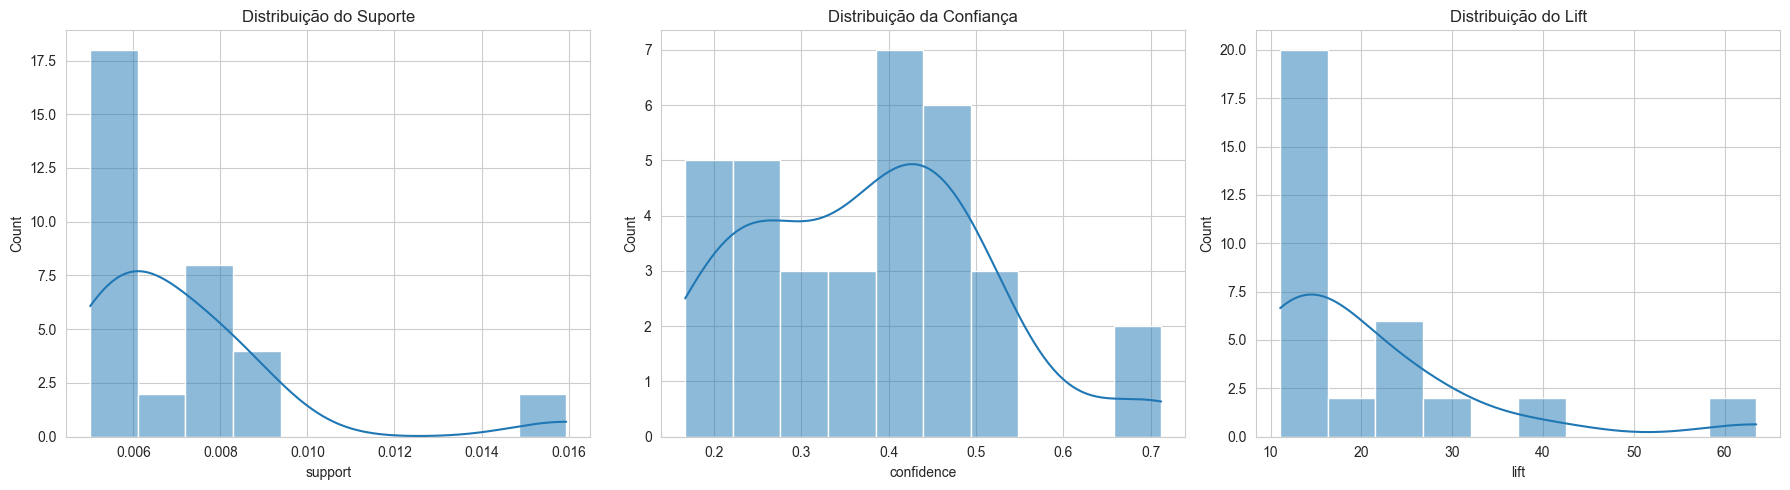

In [68]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1) # 1 linha, 3 colunas, 1º gráfico
sns.histplot(rules_para_salvar['support'], kde=True, bins=10)
plt.title('Distribuição do Suporte')

plt.subplot(1, 3, 2) # 1 linha, 3 colunas, 2º gráfico
sns.histplot(rules_para_salvar['confidence'], kde=True, bins=10)
plt.title('Distribuição da Confiança')

plt.subplot(1, 3, 3) # 1 linha, 3 colunas, 3º gráfico
sns.histplot(rules_para_salvar['lift'], kde=True, bins=10)
plt.title('Distribuição do Lift')

plt.tight_layout()
plt.show()

Matriz criada com sucesso.


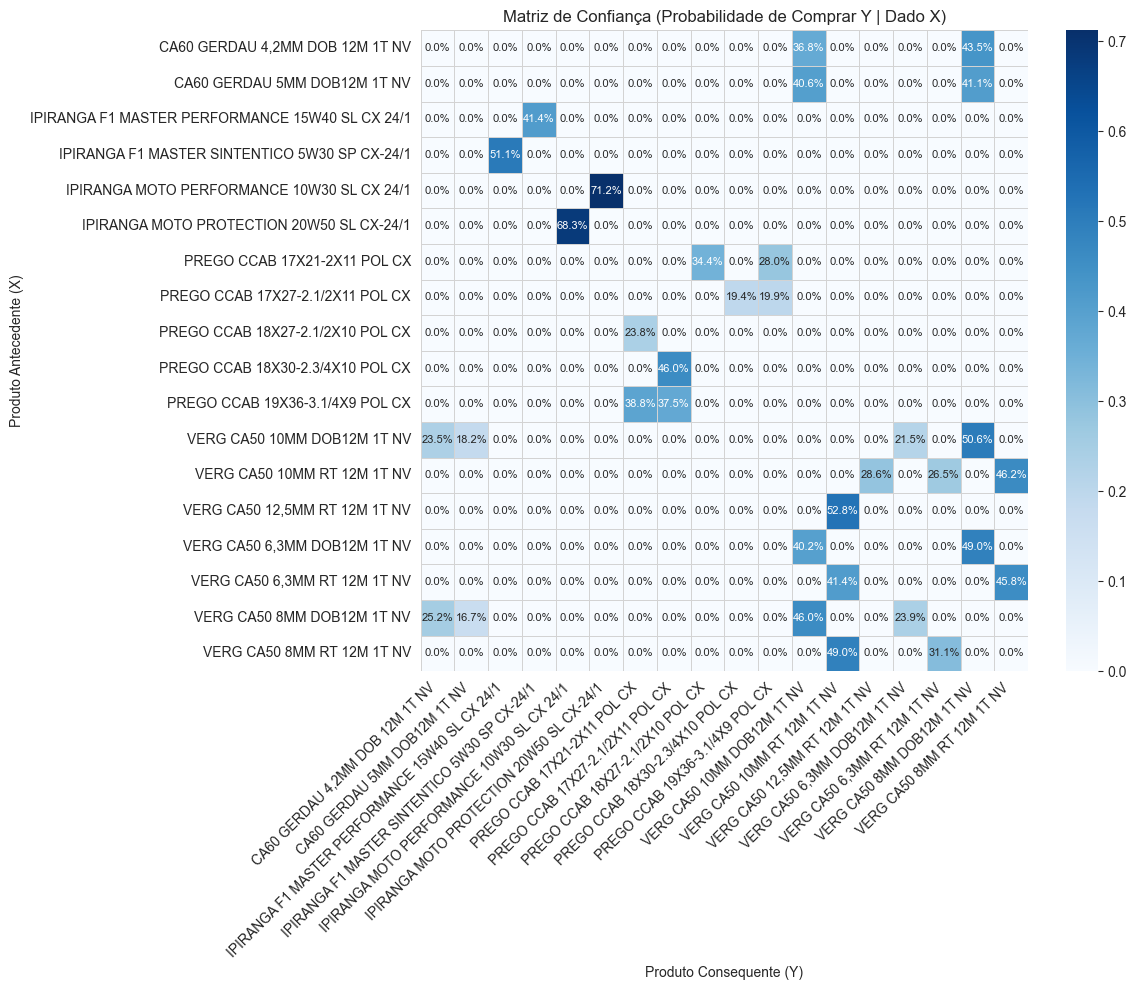

In [69]:
try:
    confidence_matrix = rules_para_salvar.pivot_table(
        index='Nomes_Antecedents',
        columns='Nomes_Consequents',
        values='confidence'
    )
    confidence_matrix = confidence_matrix.fillna(0)
    print("Matriz criada com sucesso.")

    # 2. Criar o Heatmap com Anotações Menores
    plt.figure(figsize=(12, 10)) # Ajuste o tamanho conforme necessário

    sns.heatmap(
        confidence_matrix,
        annot=True,
        fmt=".1%",
        cmap="Blues",
        linewidths=.5,
        linecolor='lightgray',
        # --- MODIFICAÇÃO AQUI ---
        annot_kws={'size': 8}  # Define o tamanho da fonte da anotação para 8
        # --- FIM DA MODIFICAÇÃO ---
    )

    plt.title('Matriz de Confiança (Probabilidade de Comprar Y | Dado X)')
    plt.xlabel('Produto Consequente (Y)')
    plt.ylabel('Produto Antecedente (X)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except KeyError as e:
    print(f"Erro: Verifique se as colunas 'Nomes_Antecedents', 'Nomes_Consequents', 'confidence' existem no DataFrame.")
    print(e)
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Usando 34 regras para construir o grafo.


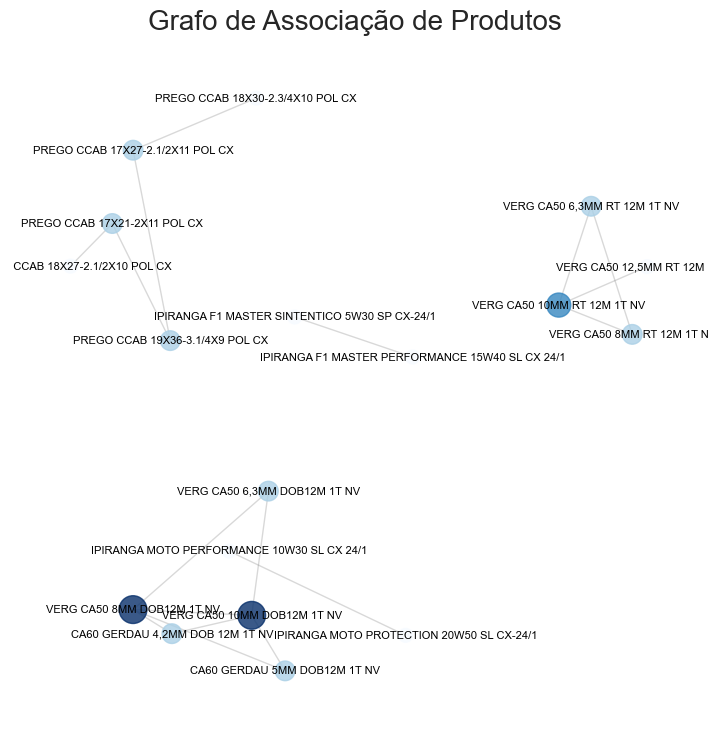

In [72]:
# --- 1. Preparar Dados (Opcional: Filtrar regras para clareza) ---
# Se você tiver muitas regras, filtre pelas mais fortes, por exemplo:
min_lift_threshold = 1 # Mantenha as regras que já atendem seu critério inicial ou aumente
rules_filtradas = rules_para_salvar[rules_para_salvar['lift'] >= min_lift_threshold].copy()

# Se ainda assim forem muitas, pode aumentar mais o threshold ou pegar top N
# rules_filtradas = rules_filtradas.sort_values('lift', ascending=False).head(50) # Ex: top 50

if rules_filtradas.empty:
    print("Nenhuma regra encontrada após a filtragem. Verifique o threshold.")
else:
    print(f"Usando {len(rules_filtradas)} regras para construir o grafo.")

    # --- 2. Criar Grafo ---
    # Criar um grafo não direcionado (G) a partir das regras
    # Usamos Nomes para os nós. Edge_attr guarda as métricas.
    G = nx.from_pandas_edgelist(
        rules_filtradas,
        source='Nomes_Antecedents',
        target='Nomes_Consequents',
        edge_attr=['lift', 'confidence'] # Adiciona métricas como atributos das arestas
    )

    # --- 3. Calcular Grau e Preparar Tamanhos ---
    # Calcular o grau (número de conexões) para cada nó
    degrees = dict(G.degree())
    nx.set_node_attributes(G, degrees, 'degree') # Armazena o grau como atributo do nó

    # Definir o tamanho dos nós proporcionalmente ao grau
    # Ajuste o fator multiplicador (ex: 100) para obter tamanhos visuais adequados
    node_sizes = [degrees[node] * 100 for node in G.nodes()]

    # --- 4. Definir Posições ---
    # Calcular a posição dos nós usando um layout
    # spring_layout tenta posicionar nós com mais conexões centralmente
    # kamada_kawai_layout é outra boa opção

    # pos = nx.kamada_kawai_layout(G)
    pos = nx.spring_layout(G, k=0.9, iterations=50) # Ajuste k para espaçamento

    # --- 5. Desenhar ---
    plt.figure(figsize=(9, 9)) # Tamanho grande para grafos

    # Desenhar os nós
    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color=list(degrees.values()), # Cor baseada no grau (opcional)
        cmap=plt.cm.Blues, # Esquema de cores para os nós
        alpha=0.8
    )

    # Desenhar as arestas
    # Pode-se variar a cor/espessura com base no lift/confidence (mais avançado)
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3, # Deixar arestas mais transparentes
        edge_color='grey'
    )

    # Desenhar os rótulos (nomes dos produtos)
    nx.draw_networkx_labels(
        G,
        pos,
        font_size=8, # Ajuste o tamanho da fonte
        font_color='black'
    )

# (Tamanho do Nó = Nº de Conexões)
    plt.title("Grafo de Associação de Produtos ", size=20)
    plt.axis('off') # Esconder eixos
    plt.show()

### Scatterplot Suport vs. Confiança

Gerando Gráfico de Dispersão: Suporte vs. Confiança (Cor/Tamanho por Lift)...


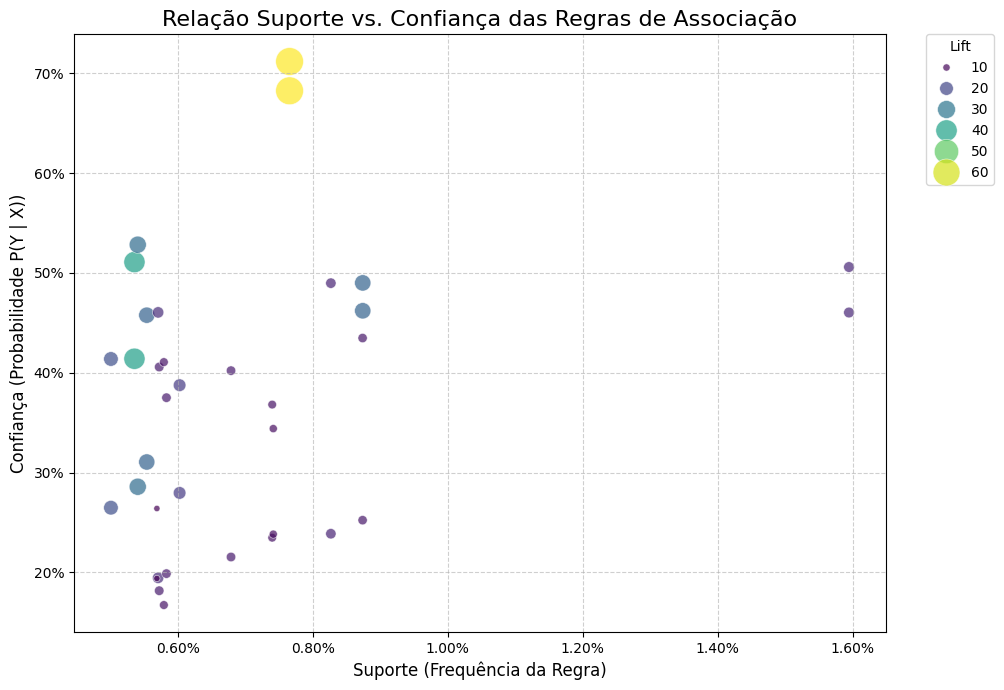

In [27]:
import matplotlib.ticker as mtick # Para formatar eixos como percentual

# Assumindo que seu DataFrame final com nomes e métricas se chama rules_para_salvar
# rules_para_salvar = pd.read_excel('regras_associacao_com_nomes.xlsx')

print("Gerando Gráfico de Dispersão: Suporte vs. Confiança (Cor/Tamanho por Lift)...")

if rules_para_salvar.empty:
    print("Não há regras para plotar.")
else:
    plt.figure(figsize=(12, 7)) # Ajuste o tamanho se necessário

    # Criar o scatter plot
    scatter = sns.scatterplot(
        data=rules_para_salvar,
        x='support',
        y='confidence',
        hue='lift',       # Cor dos pontos baseada no Lift
        size='lift',      # Tamanho dos pontos baseado no Lift
        palette='viridis',# Esquema de cores (outros: 'coolwarm', 'magma', 'plasma')
        sizes=(20, 400),  # Faixa de tamanhos dos pontos (min, max) - ajuste!
        alpha=0.7         # Transparência dos pontos
    )

    # Configurar Título e Eixos
    plt.title('Relação Suporte vs. Confiança das Regras de Associação', fontsize=16)
    plt.xlabel('Suporte (Frequência da Regra)', fontsize=12)
    plt.ylabel('Confiança (Probabilidade P(Y | X))', fontsize=12)

    # Formatar eixos X e Y como percentual
    scatter.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    scatter.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

    # Ajustar legenda
    plt.legend(title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Adicionar uma grade leve para facilitar a leitura
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Ajusta layout para caber a legenda fora
    plt.show()

### Heatmap de Lift

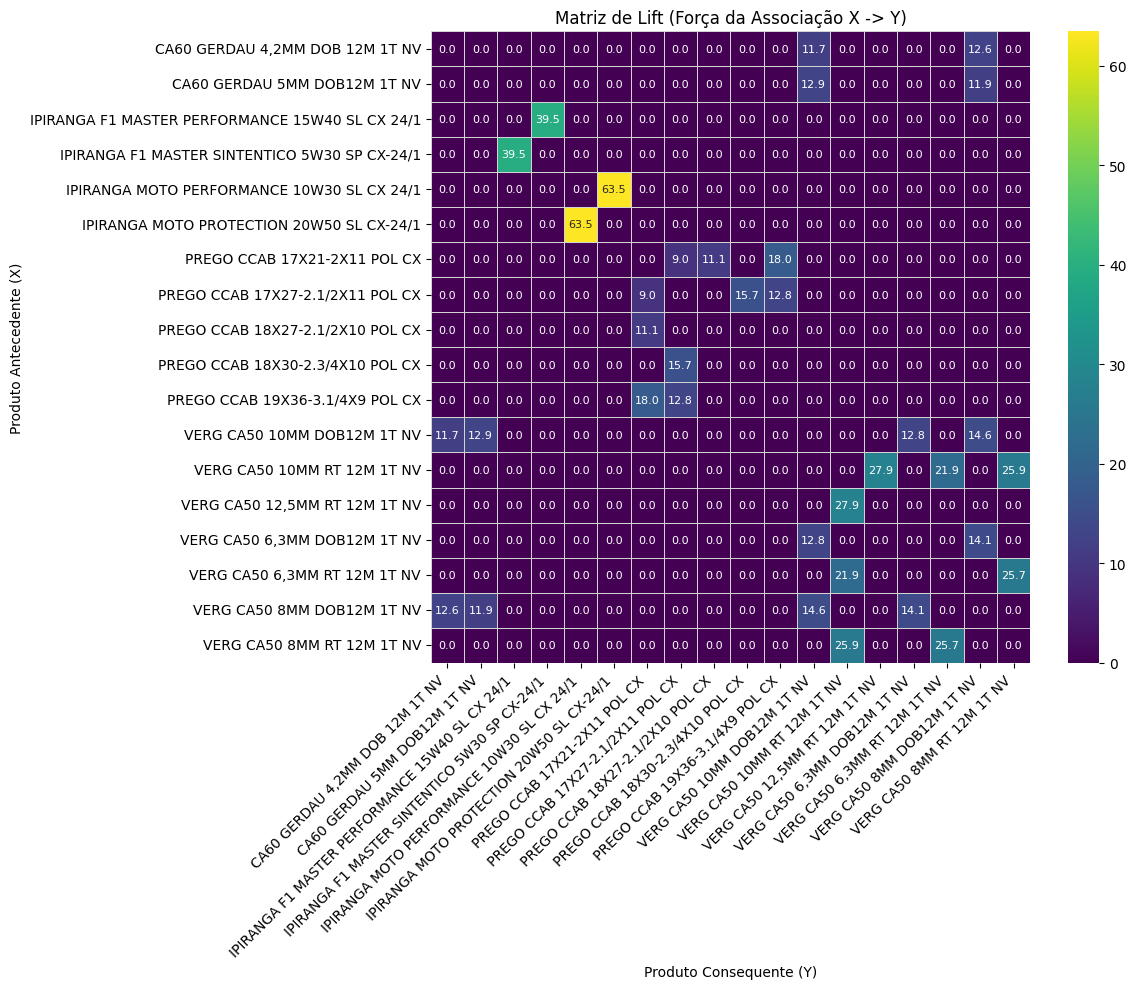

In [28]:
try:
    # Pivotar usando 'lift' como valor
    lift_matrix = rules_para_salvar.pivot_table(
        index='Nomes_Antecedents',
        columns='Nomes_Consequents',
        values='lift' # <-- MUDANÇA AQUI
    )
    lift_matrix = lift_matrix.fillna(0) # Preenche onde não há regra com 0

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        lift_matrix,
        annot=True,
        # Formatar como número decimal com 1 casa, pois Lift não é percentual
        fmt=".1f",      # <-- MUDANÇA AQUI
        # Usar um mapa de cores que destaque valores altos (ex: 'viridis', 'magma', 'YlGnBu')
        cmap="viridis", # <-- MUDANÇA AQUI
        linewidths=.5,
        linecolor='lightgray',
        annot_kws={'size': 8}
    )
    plt.title('Matriz de Lift (Força da Associação X -> Y)') # <-- MUDANÇA AQUI
    plt.xlabel('Produto Consequente (Y)')
    plt.ylabel('Produto Antecedente (X)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Ocorreu um erro: {e}")